# Uso de Segmentação de Imagens para Identificação de Bifurcações em Vasos Sanguíneos em Imagens de Retina

* Daniel Sá Barretto Prado Garcia 10374344
* Alexandre Galocha Pinto Jr 10734706

### Objetivo
O projeto busca identificar bifurcações de vasos sanguíneos em imagens de exames 
de retina para auxiliar o diagnóstico de doenças como glaucoma e diabetes. A
ideia principal é processar as imagens de exames de retina para obter imagens
com maior facilidade de identificação de bifurcação nos vasos sanguíneos e a 
partir dessas imagens processadas, calcular as bifurcações.

### Métodos a serem utilizados
O projeto utilizará segmentação de imagem para identificar os vasos sanguíneos e, em seguida, suas bifurcações. Também serão utilizadas técnicas de filtragem e morfológicas para remoção de ruído e correção de cores e sombras. 

In [1]:
import imageio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.ndimage.filters import median_filter, convolve
from scipy.ndimage import generic_filter
from skimage.morphology import opening, closing, erosion, dilation, skeletonize
from skimage.filters import threshold_local, gaussian
from skimage import measure 
import cv2
plt.style.use('dark_background')

## Leitura da imagem
Utilizou-se a biblioteca imageio para realizar a leitura da imagem.

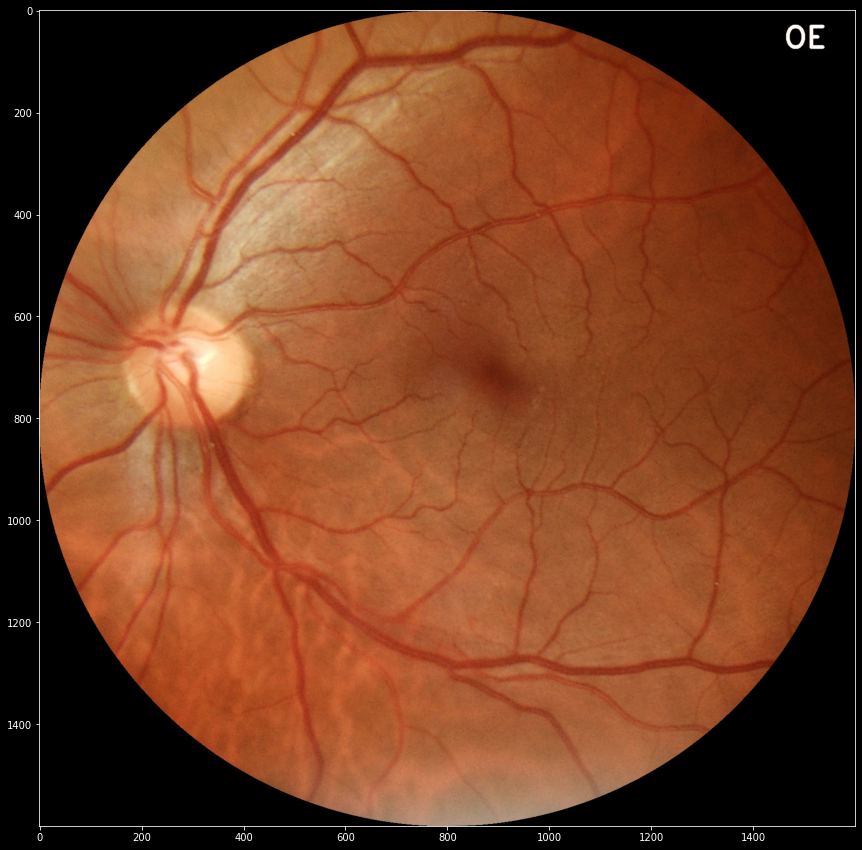

In [2]:
img = imageio.imread('images/2.jpg')

plt.figure(figsize=(15,15))
plt.imshow(img)

## Pré-Processamento
Nessa etapa do projeto são realizados diversos técnicas de processamento de imagem visando obter uma melhor representação dos vasos sanguíneos presentes no exame de retina. 

### Canal Verde
Inicialmente, seleciona-se apenas o canal verde de uma imagem, que traz uma boa representação dos vasos e diminui a quantidade de dados a serem processados (de 3 para 1 canal de cor apenas).

(1600, 1600)


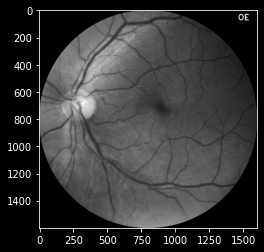

In [3]:
img_g = img[:,:,1]
print(img_g.shape)
plt.imshow(img_g,cmap='gray')

### Abertura (Opening)
Realiza-se então uma operação de abertura da imagem para remover parte das sombras e das reflexões (manchas brancas) presentes na imagem, visando obter uma imagem mais próxima da real, sem influência da câmera utilizada.

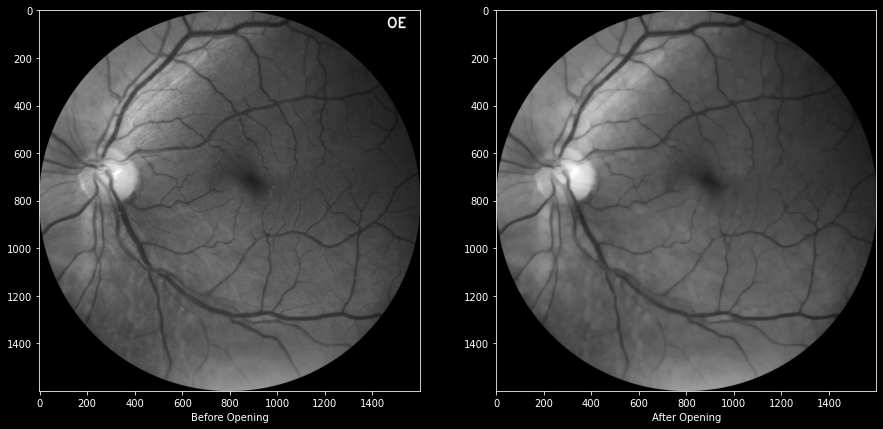

In [4]:
ker = np.ones((13, 13))
img_opening = opening(img_g, ker)

plt.figure(figsize=(15,15))
plt.subplot(121)
plt.xlabel('Before Opening')
plt.imshow(img_g, cmap="gray")
plt.subplot(122)
plt.xlabel('After Opening')
plt.imshow(img_opening, cmap="gray")


A função abaixo foi criada para facilitar o processamento dos próximos passos. Essa função recebe uma imagem e aplica o filtro especificado , seguindo o tamanho de núcleo e o tipo de filtro indicados. Ela utiliza filtros de média, mediana ou gaussiano.

In [5]:
def filter_img(img, kernel_size=3, filter_type="mean"):
    if filter_type == "mean":
        weights = np.full((kernel_size, kernel_size), 1.0/(kernel_size**2))
        return convolve(img, weights=weights, mode="constant", cval=0)
    elif filter_type == "median":
        return median_filter(img, size=kernel_size)
    elif filter_type == "gaussian":
        kernel = np.zeros((kernel_size, kernel_size))
        kernel[kernel_size//2, kernel_size//2] = 1
        kernel = gaussian(kernel, sigma=1, mode='reflect')
        return convolve(img, weights=kernel, mode="constant", cval=0)
    else:
        print('Error! Filter should be either mean, median or gaussian!')
        return None

### Cálculo do Background (Plano de Fundo)
Com o objetivo final de isolar os vasos sangúineos, foram utilizados diversos filtros na imagem buscando retirar dela o plano de fundo. A ideia é de obter-se o fundo da imagem e removê-lo, resultando assim em uma imagem com apenas as partes mais relevantes, que no caso são os vasos sanguíneos.   
Para obter o background da imagem os filtros utilizados foram:
* filtro média com tamanho 13, seguido de;
* filtro gaussiano de tamanho 15;
* filtro mediana de tamanho 60;

A aplicação desta série de filtros tem como objetivo borrar a imagem original. Deste modo, todos os detalhes mais finos são removidos (que no caso seriam os vasos sanguíneos), e assim, gera-se uma imagem de como seria o exame sem os vasos sangúineos.

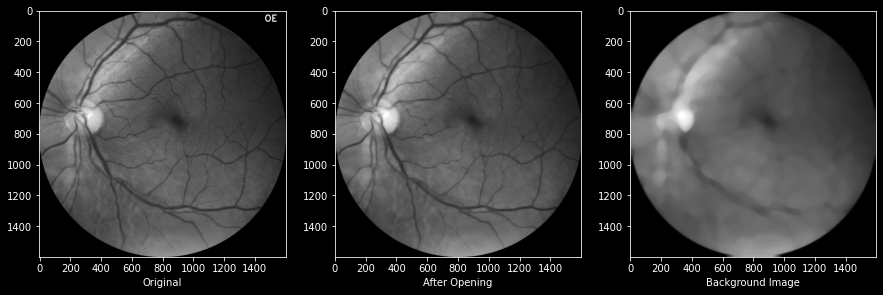

In [6]:
background = filter_img(img_opening, kernel_size=13, filter_type="mean")
background = filter_img(background, kernel_size=15, filter_type="gaussian")
background = filter_img(background, kernel_size=60, filter_type="median")

plt.figure(figsize=(15,15))
plt.subplot(131)
plt.xlabel("Original")
plt.imshow(img_g, cmap="gray")
plt.subplot(132)
plt.xlabel("After Opening")
plt.imshow(img_opening, cmap="gray")
plt.subplot(133)
plt.xlabel("Background Image")
plt.imshow(background, cmap="gray")

As funções abaixo foram retiradas dos códigos fornecidos pelo professor da disciplina. Elas foram utilizadas para melhorar a diferenciação nos níveis de cor da imagem. Isso trouxe uma melhora significativa na visualização dos vasos (por olhos humanos), mas não impactou de maneira tão positiva o processamento realizado sobre a imagem.

De qualquer maneira, foram mantidos os resultados obtidos, já que justificam as decisões feitas no código final.

In [7]:
def histogram(A, no_levels):
    # gets the size of the input matrix
    N, M = A.shape
    # creates an empty histogram with size proportional to the number of graylevels 
    hist = np.zeros(no_levels).astype(int)

    # computes for all levels in the range
    for i in range(no_levels):
        # sum all positions in which A == i is true
        pixels_value_i = np.sum(A == i)
        # store it in the histogram array
        hist[i] = pixels_value_i
            
    return(hist)

def histogram_equalization(A, no_levels):
    # computes the image histogram
    hist = histogram(A,  no_levels)
    
    # creates an empty cumulative histogram
    histC = np.zeros(no_levels).astype(int)

    # computes the cumulative histogram
    histC[0] = hist[0] # first value (intensity 0)
    # from intensity 1 to no_levels-1
    for i in range(1,  no_levels):
        histC[i] = hist[i] + histC[i-1]

    # the vector below is used to store the actual transformation function
    # it allows us to later visualize what was the function that computed
    # the equalisation
    hist_transform = np.zeros(no_levels).astype(np.uint8)
    
    # gets the size of the input image
    N, M = A.shape
    
    # create the image to store the equalised version
    A_eq = np.zeros([N,M]).astype(np.uint8)
    
    # for each intensity value, transforms it into a new intensity
    # using the np.where() function 
    for z in range(no_levels):
        # computes what would be the output level 's' for an input value 'z'
        s = ((no_levels-1)/float(M*N))*histC[z]
        
        # for every coordinate in which matrix A has the value 'z'
        # assigns the transformed/equalised value 's'
        A_eq[ np.where(A == z) ] = s
        
        # store the tranformation function
        hist_transform[z] = s
    
    return (A_eq, hist_transform)

### Remoção do Background

Em seguida, calcula-se a diferença (uma subtração simples) da imagem com o background calculado. Isso visa destacar os vasos sanguíneos da imagem. 

Porém como parecia ser difícil a visualização dos vasos, foi realizado o cálculo de equalização por meio de histograma para melhorar a distribuição dos tons de cinza na imagem, o que melhora muito a visualização dos vasos sanguíneos. No entanto, muito barulho é inserido e acabou atrapalhando o resto do processamento. Ambas abordagens foram seguidas a seguir, porém obteve-se bons resultados apenas com a abordagem inicial.

Text(0.5, 0, 'Equalized histogram')

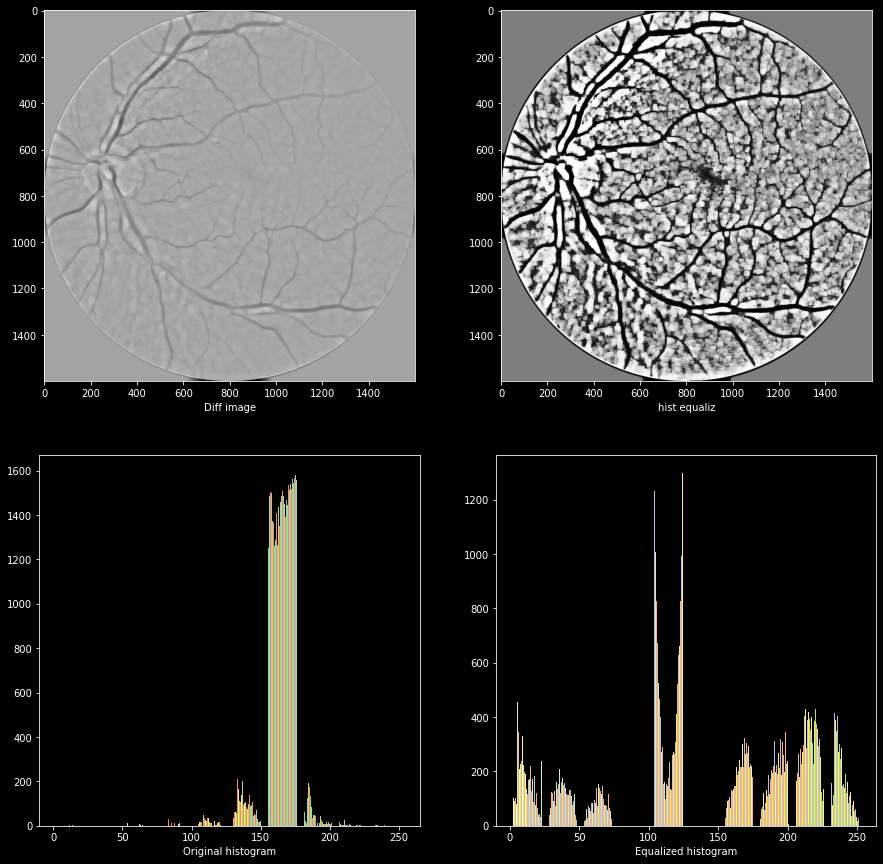

In [8]:
diff_img = img_opening.astype(np.int64) - background.astype(np.int64)
diff_img = ((diff_img - np.min(diff_img)) / (np.max(diff_img) - np.min(diff_img))*255).astype(np.uint8)
diff_img_eq, _ = histogram_equalization(diff_img, 256)

plt.figure(figsize=(15,15))
plt.subplot(221)
plt.xlabel("Diff image")
plt.imshow(diff_img, cmap="gray")

plt.subplot(222)
plt.xlabel("hist equaliz")
plt.imshow(diff_img_eq, cmap="gray")

plt.subplot(223)
plt.xlabel('Original histogram')
plt.hist(diff_img)

plt.subplot(224)
plt.hist(diff_img_eq)
plt.xlabel('Equalized histogram')

## Thresholding
A etapa de segmentação utiliza a imagem de diferença sem equalização obtida anteriormente para o cálculo de uma nova imagem utilizando a técnica de thresholding.

Esta etapa visa obter uma imagem que dividisse as regiões mais escuras das mais claras na imagem, para então separar as regiões de interesse do plano de fundo. Neste caso, os vasos sangúineos são as regiões de interesse e serão as mais claras. 

Sendo assim, foram aplicados dois métodos de thresholding: um global e um adaptativo (ou local). O global define um valor limitante global e separa valores maiores e menores que ele em duas classes. Já o thresholding adaptativo utiliza informações de píxels vizinhos para realizar o cálculo de acordo com a função escolhida. Isso resulta em um melhor resultado em imagens que possuem diferenças no nível de iluminação ao longo da imagem, que é o caso.

Inicialmente os resultados do threshold global pareceram serem mais promissores do que o adaptativo, mas no decorrer do processo o threshold adaptativo se mostrou mais adequado.

Text(0.5, 0, 'Adaptive threshold')

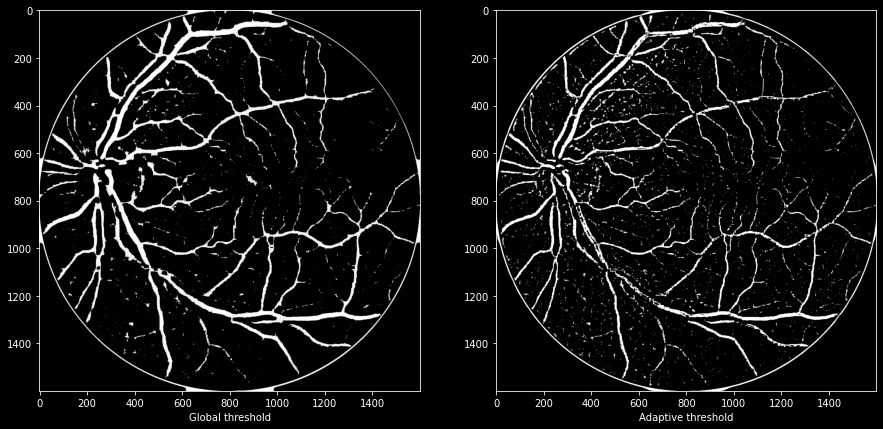

In [9]:
_, global_thresh = cv2.threshold(np.bitwise_not(diff_img_eq), 230, 255, cv2.THRESH_TOZERO)
adaptive_thresh = cv2.adaptiveThreshold(diff_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 41, 5)
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(global_thresh, cmap="gray")
plt.xlabel('Global threshold')
plt.subplot(122)
plt.imshow(adaptive_thresh, cmap="gray")
plt.xlabel('Adaptive threshold')

## Pós-Processamento
### Operadores morfológicos
Com as imagens devidamente segmentadas, inicia-se o processamento com operadores morfológicos, a fim de obter-se uma melhor definição dos vasos. 

Foram aplicados os operadores de fechamento e abertura em sequência. A operação de fechamento é realizada com o intuito de expandir a área branca da imagem, buscando unir vasos que tinham sido espaçados. A partir dessa imagem com melhores junções de vasos então buscamos remover o ruído utilizando o operador de abertura. 

Um fato estranho que percebemos foi a aparente inversão dos operadores: o esperado é que o opening "aumentasse" a parte branca, preenchendo ligações de vasos e o closing removesse os pequenos pontos. É possível que essa inversão pode acontecer na conversão de tipos de `bool` (resultado do threshold) para `uint8`. Mas o fato mais importante é, apenas estão invertidos, então ao invés de aplicar opening e depois closing (que seria o que gostaríamos de aplicar), aplica-se closing e depois opening, obtendo o resultado esperado.

Text(0.5, 0, 'Adaptive threshold after closing and opening')

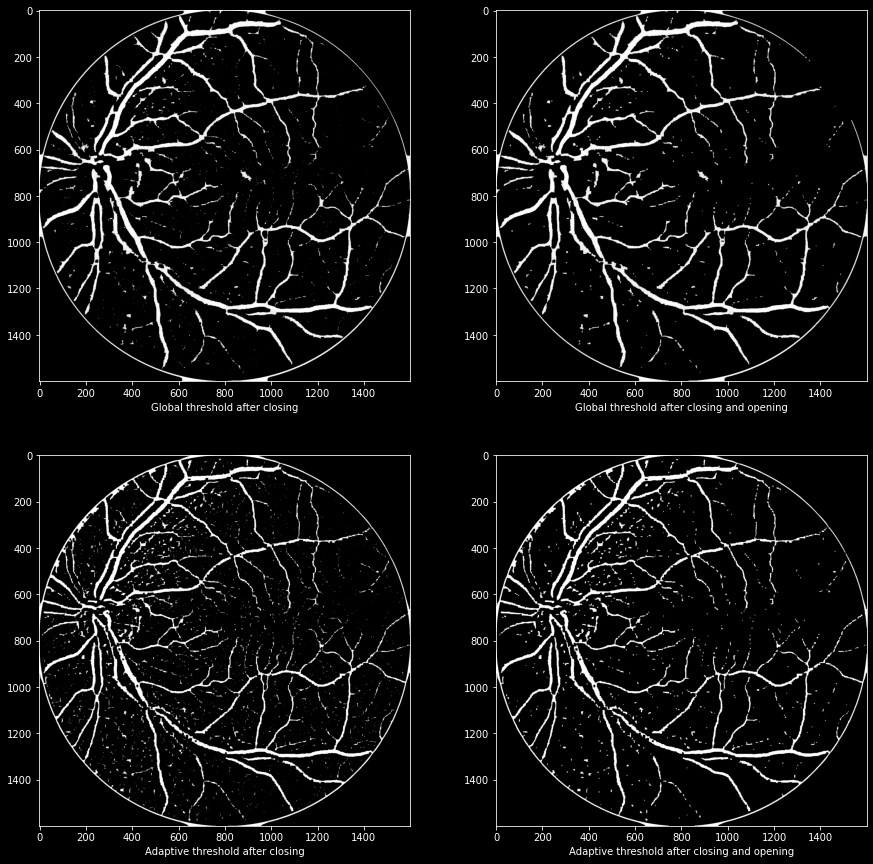

In [10]:
global_thresh_clo = closing(global_thresh.astype(np.uint8), np.ones((3,3)))
global_thresh = opening(global_thresh_clo.astype(np.uint8), np.ones((3,3)))
adaptive_thresh_clo = closing(adaptive_thresh.astype(np.uint8), np.ones((7,7)))
adaptive_thresh = opening(adaptive_thresh_clo.astype(np.uint8), np.ones((3,3)))

plt.figure(figsize=(15,15))
plt.subplot(221)
plt.imshow(global_thresh_clo, cmap='gray')
plt.xlabel('Global threshold after closing')
plt.subplot(222)
plt.imshow(global_thresh, cmap='gray')
plt.xlabel('Global threshold after closing and opening')
plt.subplot(223)
plt.imshow(adaptive_thresh_clo, cmap='gray')
plt.xlabel('Adaptive threshold after closing')
plt.subplot(224)
plt.imshow(adaptive_thresh, cmap='gray')
plt.xlabel('Adaptive threshold after closing and opening')

### Remover áreas pequenas
Agora, para obter-se uma imagem que possua apenas os vasos, é necessário remover o ruído gerado junto a imagem nas etapas anteriores. Para isto, divide-se a imagem em várias regiões conexas e seleciona-se apenas as regiões que sejam maiores que uma area mínima `min_area`. Isto permite a remoção de pequenas áreas que, em sua maoir parte, são ruído. Este método pode ser encotrado [aqui](https://medium.com/swlh/image-processing-with-python-connected-components-and-region-labeling-3eef1864b951). 

A função abaixo faz exatamente esse processo: divide a imagem em várias regiões, escolhendo entre elas apenas as que possuem uma determinada área mínima (pelo parâmetro `min_area`). Então é formada uma nova imagem com apenas as regiões que respeitam essa área mínima.

In [11]:
# https://medium.com/swlh/image-processing-with-python-connected-components-and-region-labeling-3eef1864b951
def remove_small_areas(img, min_area):
    label_img = measure.label(img, background=0 ,connectivity=2)
    regions = measure.regionprops(label_img)

    masks = []
    bbox = []
    list_of_index = []
    for num, x in enumerate(regions):
        area = x.area
        if (area>min_area):
            masks.append(regions[num].convex_image)
            bbox.append(regions[num].bbox)   
            list_of_index.append(num)

    for box, mask in zip(bbox, masks):
        reduced_img = img[box[0]:box[2], box[1]:box[3]] * mask

    mask = np.zeros_like(label_img)
    for x in list_of_index:
        mask += (label_img==x+1).astype(int)
    reduced_img  =  img * mask

    return reduced_img


Esta função é utilizada para tentar remover os pontos (áreas pequenas) da imagem. Os resultados foram bem satisfatórios com a imagem gerada pelo threshold adaptativo, enquanto que a gerada pelo threshold global gerou muitas perdas de informação. A partir desse ponto decidiu-se utilizar a imagem gerada pelo processo adaptativo. 

Text(0.5, 0, 'Adaptive threshold after removing small areas')

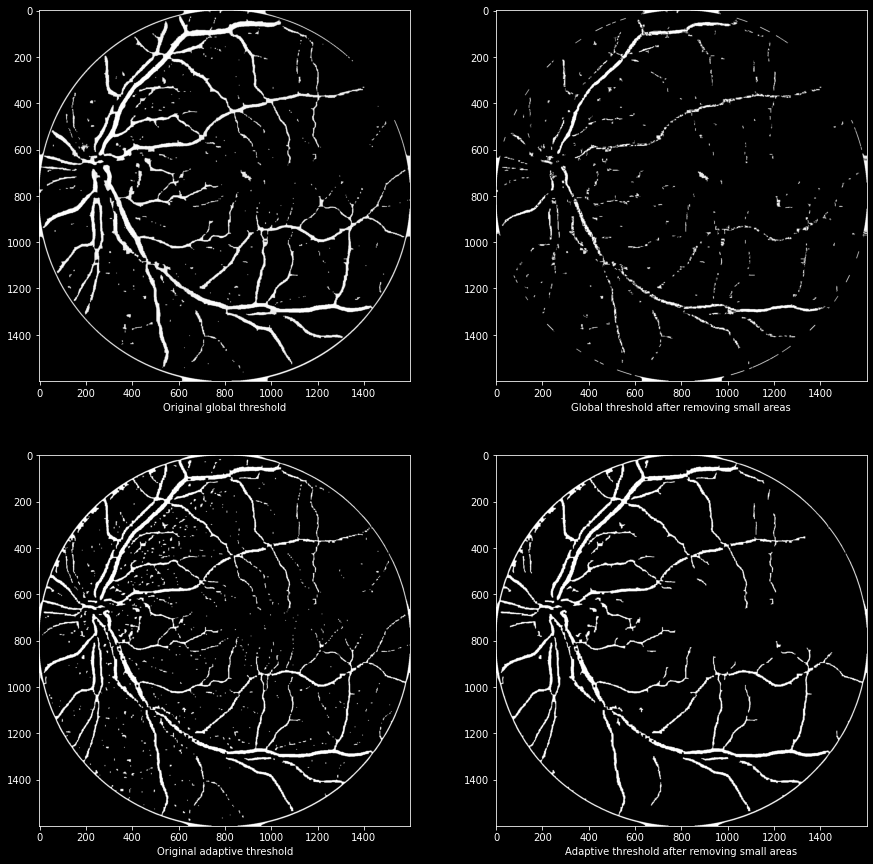

In [12]:
reduced_global = remove_small_areas(global_thresh, 30)
reduced_adaptive = remove_small_areas(adaptive_thresh, 150)
plt.figure(figsize=(15,15))
plt.subplot(221)
plt.imshow(global_thresh, cmap="gray")
plt.xlabel('Original global threshold')
plt.subplot(222)
plt.imshow(reduced_global, cmap="gray")
plt.xlabel('Global threshold after removing small areas')

plt.subplot(223)
plt.imshow(adaptive_thresh, cmap="gray")
plt.xlabel('Original adaptive threshold')
plt.subplot(224)
plt.imshow(reduced_adaptive, cmap="gray")
plt.xlabel('Adaptive threshold after removing small areas')

### Esqueletização
Após gerar uma imagem contendo apenas os vasos sanguíneos, inicia-se o processo de esqueletização. Esta etapa visa obter uma imagem que descreva por onde vasos sanguíneos passam, sem se importar com sua espessura.   
Essa imagem esqueletizada será usada para o cálculo de ponto candidatos a serem bifurcações e também para a verificação se de fato dado ponto é uma bifurcação.

Text(0.5, 0, 'Adatptive threshold skeleton')

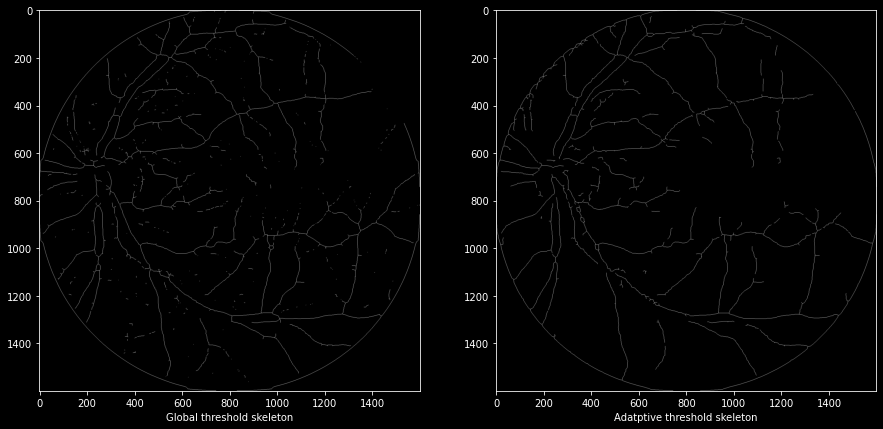

In [13]:
global_skeleton = skeletonize(global_thresh.astype(bool))
adaptive_skeleton = skeletonize(reduced_adaptive.astype(bool))
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(global_skeleton, cmap="gray")
plt.xlabel('Global threshold skeleton')
plt.subplot(122)
plt.imshow(adaptive_skeleton, cmap='gray')
plt.xlabel('Adatptive threshold skeleton')

## Cálculo de bifurcações
Com o esqueleto e a imagem dos vasos sanguíneos em mãos, inicia-se o processo de calcular onde se encontram as bifurcações da imagem. Sendo assim, primeiramente marcam-se potenciais bifurcações e depois, com auxílio de funções que medem a largura de um vaso, valida-se a possibilidade do ponto ser de fato uma bifurcação.

### Marcando Lankdmarks
A função de identificação de possíveis candidatos segue os seguintes passos para cada píxel diferente de 0 da imagem de esqueleto:
* Cria-se uma máscara de tamanho $3\times 3$ com todos valores iguais a 1, exceto pelo valor da posição central. Essa máscara representa a vizinhança do dado píxel.
* Calcula-se a matriz que representa a vizinhança do píxel de coordenada $(x,y)$
* Realiza-se a operação de "E" lógico (*bitiwise AND*) entre a máscara e a vizinhança do píxel. Este processo resulta nos píxels que são intersecção entre ambos.
* Soma-se o resultado de todas as células da intersecção.
* Caso o resultado seja 3 ou 4, adiciona-se o ponto na lista juntamente ao resultado da soma 

In [14]:
def mark_potential_landmark(img):
    size = 3
    a = size//2
    mask = np.ones((size,size))
    mask[1:-1,1:-1] = 0
    mask = mask.astype(bool)
    N,M = img.shape
    landmarks = []
    coords = np.argwhere(img)
    for (x,y) in coords:
      #inside circle
      if(x-a < 0 or y-a < 0 or x+a+1 > N or y+a+1 > M ):
        continue
      sub_img = img[x-a:x+a+1, y-a:y+a+1]
      img_sum = np.sum(np.bitwise_and(sub_img, mask))
      if(img_sum == 3 or img_sum == 4):
          landmarks.append((x,y,img_sum))
    return landmarks

Então, para a imagem do esqueleto, é chamada a função e captura-se todas as potenciais bifurcações.

In [15]:
land = mark_potential_landmark(adaptive_skeleton)
len(land)

624

Para entender melhor se o processo estava funcionando, realiza-se o plot abaixo dos vários pontos gerados pela função de marcação. Verifica-se então que, como o esperado, os pontos marcados estavam sobre linhas, o que mostra que de fato o algoritmo estava funcionando.

Text(0.5, 0, 'Adaptive Skeleton with Landmarks')

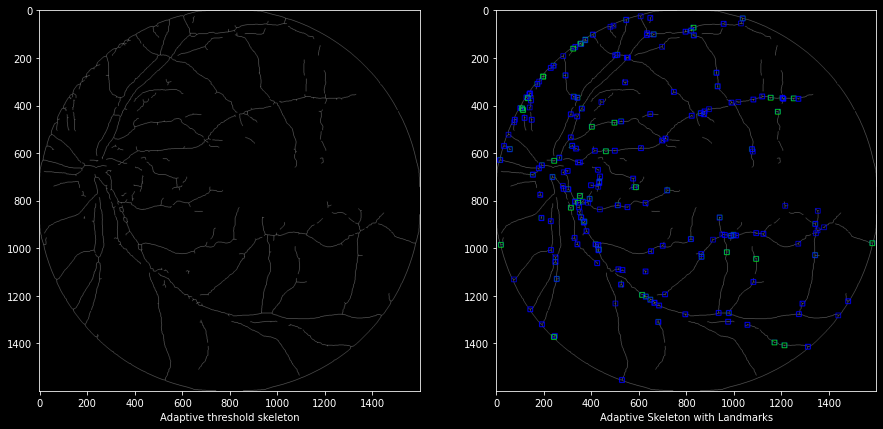

In [16]:
N,M =adaptive_skeleton.shape
temp = np.zeros((N,M,3)).astype(np.uint8)
temp[:,:,0] = adaptive_skeleton.astype(np.uint8)
temp[:,:,1] = adaptive_skeleton.astype(np.uint8)
temp[:,:,2] = adaptive_skeleton.astype(np.uint8)
temp[temp == 1] = 255
for (y, x, img_sum) in land:
    if img_sum == 3:
        cv2.rectangle(temp, (x-10,y-10), (x+10, y+10), (0,0,255), 2)
    else:
        cv2.rectangle(temp, (x-10,y-10), (x+10, y+10), (0,255,0), 2)
    
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(adaptive_skeleton, cmap='gray')
plt.xlabel('Adaptive threshold skeleton')
plt.subplot(122)
plt.imshow(temp, cmap="gray")
plt.xlabel('Adaptive Skeleton with Landmarks')

## Validação da seleção
Com os pontos candidatos a serem bifurcações ou intersecções em mãos,
é necessário encontrar uma maneira de validar cada um deles. Para isto a
ideia utilizada foi de calcular as larguras de cada vaso sanguíneo e utilizá-las
para a criação de uma máscara circular, com a qual foi realizada uma contagem do
número de intersecções com o esqueleto da imagem em cada ponto.

### Cálculo de larguras
Primeiramente deve-se calcular a largura dos vasos que os pontos se encontram. Sendo assim, foi definida a função abaixo que basicamente calcula para cada uma das 4 direções (vertical, horizontal e as duas diagonais) o tamanho e retorna o menor deles como a largura.

In [17]:
def calculate_widths(img, landmarks):
    widths = []
    for x,y,node_type in landmarks:
        #down        
        i = x
        j = y
        vert_dist = 0
        while(j<1600 and img[i,j]!=0):
            vert_dist+=1
            j+=1
        
        #up
        i=x
        j=y
        while(j>=0 and img[i,j]!=0 ):
            vert_dist+=1
            j-=1
        
        #right
        horiz_dist = 0
        i = x
        j = y
        while(i<1600 and img[i,j]!=0):
            horiz_dist+=1
            i+=1

        #left
        i=x
        j=y
        while(i>=0 and img[i,j]!=0):
            horiz_dist+=1
            i-=1
        
        #down right
        i=x
        j=y
        s_diag_dist=0
        while(i<1600 and j<1600 and img[i,j]!=0):
            i+=1
            j+=1
            s_diag_dist+=1
        
        #up left
        i=x
        j=y
        while(i>=0 and j>=0 and img[i,j]!=0):
            i-=1
            j-=1
            s_diag_dist+=1

        #down left
        i=x
        j=y
        p_diag_dist=0
        while(i>=0 and j<1600 and img[i,j]!=0):
            i-=1
            j+=1
            p_diag_dist+=1

        #up right
        i=x
        j=y
        while(i<1600 and j>=0 and img[i,j]!=0):
            i+=1
            j-=1
            p_diag_dist+=1
        min_width = np.min([vert_dist, horiz_dist, p_diag_dist, s_diag_dist])
#         mean_width = np.mean([vert_dist, horiz_dist, p_diag_dist, s_diag_dist])
        widths.append([(x,y), np.ceil(min_width).astype(int), node_type])
    return widths

Chamamos a função passando a imagem `reduced_adaptative` que é a imagem após o
threshold e também remoção de ruído.

In [18]:
widths = calculate_widths(reduced_adaptive, land)

#### Máscara Circular
Agora para dar sequência, é preciso utilizar uma máscara circular de raio $r = 1.5 * L$, sendo $L$ a largura calculada do vaso sanguíneo em cada ponto. A função auxiliar abaixo, cria uma matriz de tamanho $diametro \times diametro$ e preenche com uma máscara circular com o dado diâmetro.

In [19]:
def make_circle(diameter):
    diameter += 2
    
    radius = diameter // 2
    
    circle = np.zeros((diameter, diameter)).astype(np.uint8)
    c = radius
    y, x = np.ogrid[-radius:radius, -radius:radius]
    index = x ** 2 + y ** 2 < radius ** 2
    circle[c - radius:c + radius, c - radius: c + radius][index] = 1
    
    diameter_in = diameter - 2
    radius_in = diameter_in // 2
    
    inside = np.zeros((diameter, diameter)).astype(np.uint8)
    c = radius
    y, x = np.ogrid[-radius:radius, -radius:radius]
    index = x ** 2 + y ** 2 < radius_in ** 2
    inside[c - radius:c + radius, c - radius: c + radius][index] = 1
    
    
    return np.bitwise_xor(circle, inside)[1:-1, 1:-1]

### Verificação dos Candidatos
A função que realiza a verificação de cada um dos pontos candidados segue a seguinte
lógica:
* Seleciona um nó, a largura calculada e o tipo previso na marcação;
* Calcula a matriz que possua a máscara circular de raio $r=1.5*L$, sendo $L$ a largura calculada;
* Realiza a sobreposição do circulo na subimagem centralizada no ponto em questão
e calcula a quantidade de intersecções do circulo com as linhas da imagem esqueletizada;
* Caso tenha 3 intersecções e a marcação foi do tipo 3, é uma bifurcação; caso tenha 
4 e a marcação seja do tipo 4, é uma intersecção;
* O processo é repetido para cada um dos pontos e as intersecções e bifurcações são 
salvas em vetores separados.

In [20]:
def validate_bifurcations_and_intersections(widths, skeleton_img):
    bifurcations = []
    intersections = []
    for (x,y), width, node_type in widths:
        diam = 3*width
        diam += 1 if diam % 2 == 0 else 0
        radius = diam//2
        if(x-radius < 0 or y-radius < 0 or x+radius+1>skeleton_img.shape[0] or y+radius+1 > skeleton_img.shape[1]):
          continue
        circle = make_circle(diam)
        sub_img = skeleton_img[x-radius:x+radius+1, y-radius:y+radius+1].astype(bool)
        
        circle_sum = np.sum(np.bitwise_and(sub_img, circle))
        if(circle_sum == 3 and node_type == 3):
            bifurcations.append((x,y))
        elif(circle_sum == 4 and node_type == 4):
            intersections.append((x,y))
    return bifurcations, intersections

In [21]:
bifurcations, intersections = validate_bifurcations_and_intersections(widths, adaptive_skeleton)
print(len(bifurcations), len(intersections))

118 16


# Resultado obtido
Finalmente, plota-se o resultado final tendo as bifurcações marcadas com quadrados azuis e as intersecções marcadas com quadrados vermelhos.

Os resultados obtidos foram bem satisfatórios, já que marcaram corretamente uma quantidade considerável de pontos. No entanto, bifurcações de vasos com uma largura menor não são identificadas, já que muitas vezes a informação deste tipo de vaso é perdida ao longo da série de processamentos. Há também um certo número de falsos positivos que se dão devido à interpretação do limite da imagem como um vaso sanguíneo, ruído ainda presente em algumas regiões do esqueleto e reflexões (manchas) na imagem. É possível então atingir um melhor resultado utilizando técnicas de aprendizado de máquina para aprimorar a escolha de parâmetros para cada tipo de imagem e, então, melhorar a remoção de ruído sem perder de informação.

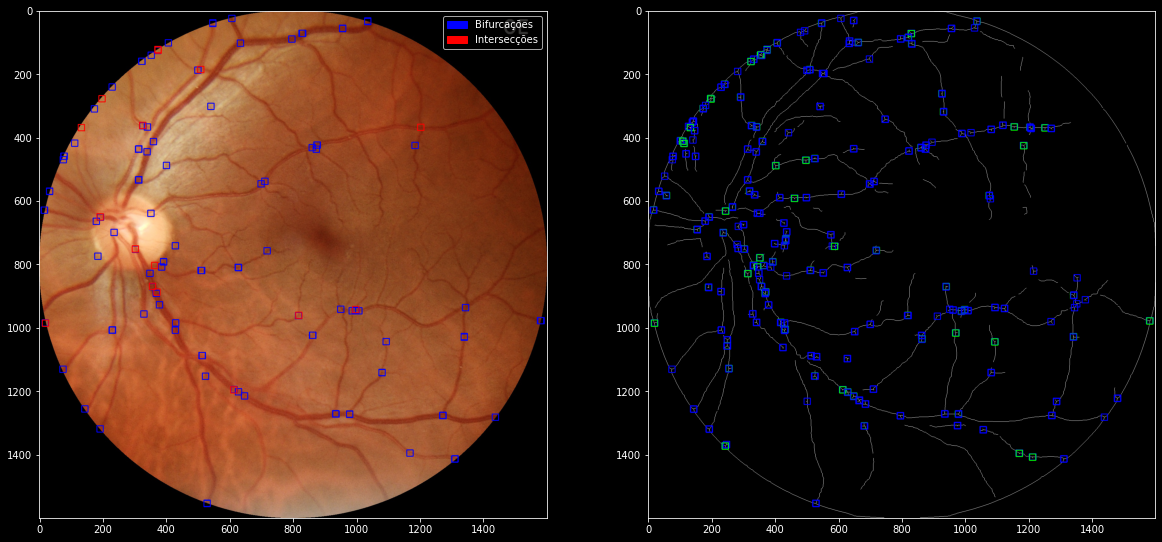

In [32]:
final = img.copy()

for (y,x) in bifurcations:
    cv2.rectangle(final, (x-10,y-10), (x+10, y+10), (0,0,255), 2)
for (y,x) in intersections:
    cv2.rectangle(final, (x-10,y-10), (x+10, y+10), (255,0,0), 2)


plt.figure(figsize=(20,20))
plt.subplot(121)
red_patch = patches.Patch(color='red', label='Intersecções')
blue_patch = patches.Patch(color='blue', label='Bifurcações')
plt.legend(handles=[blue_patch, red_patch])
plt.imshow(final)
plt.subplot(122)
plt.imshow(temp)

## Resultado Esperado
![](images/2_expected.jpg)
